## Error calculations

Error due to seperation between INTEGRAL and Earth.

In [2]:
D = 150e3 # max distance between INTEGRAL and Earth (~ 150 000 km)
r = 4 * 149597870.7 # min distance between Jupiter and Earth is ~ 4 AU 

error = D/r * 206265/60 # convert to arcmin
print("Angular error is ", error, " arcmin") # below 1', insignificant (FWHM is 12' for INTEGRAL)

Angular error is  0.8617477267341882  arcmin


Error due to seperation between INTEGRAL and Earth is negligible.

In [ ]:
error = 0.8617477267341882 # arcmin error due to distance between INTEGRAL and Earth
pixel_scale_arcmin = 0.082286 * 60 # arcmin pixel scale (taken from the header of a queried image)
print(error/pixel_scale_arcmin, "pixels")

0.17454320433896983 pixels


## Jupiter ScWs

In [21]:
from astropy.coordinates import SkyCoord
from astroquery.jplhorizons import Horizons
import pandas as pd
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
import astropy.units as u

Load the ScWs.

In [24]:
scw_ids = []
scw_versions = []
scw_start_times = []
scw_end_times = []
jupiter_ra = []
jupiter_dec = []

with open("../data/2003-01-01_2025-01-01.txt", "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split(", ")
        scw_ids.append(parts[0])
        scw_versions.append(parts[1])
        scw_start_times.append(float(parts[2]))  
        scw_end_times.append(float(parts[3]))  
        jupiter_ra.append(float(parts[4]))  
        jupiter_dec.append(float(parts[5]))  

# Sort by time and remove duplicates
unique_sorted_data = {}
for sid, ver, start, end, ra, dec in sorted(zip(scw_ids, scw_versions, scw_start_times, scw_end_times, jupiter_ra, jupiter_dec), key=lambda x: x[0]):
    if sid not in unique_sorted_data:  
        unique_sorted_data[sid] = (sid, ver, start, end, ra, dec)

scw_ids, scw_versions, scw_start_times, scw_end_times, jupiter_ra, jupiter_dec = map(list, zip(*unique_sorted_data.values()))

In [25]:
scw_list = [id + "." + ver for id, ver in zip(scw_ids, scw_versions)]
scw_durations = [(end - start)*24*60 for start, end in zip(scw_start_times, scw_end_times)]

Plot distribution of the ScWs over time and the angular seperation between the Crab and the Sun.

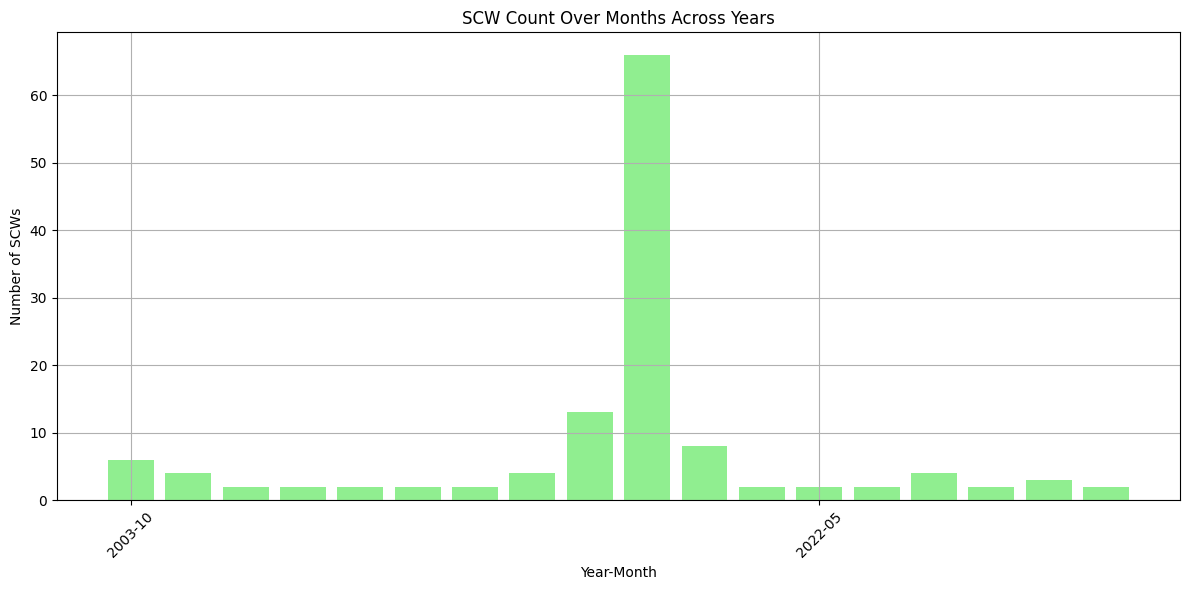

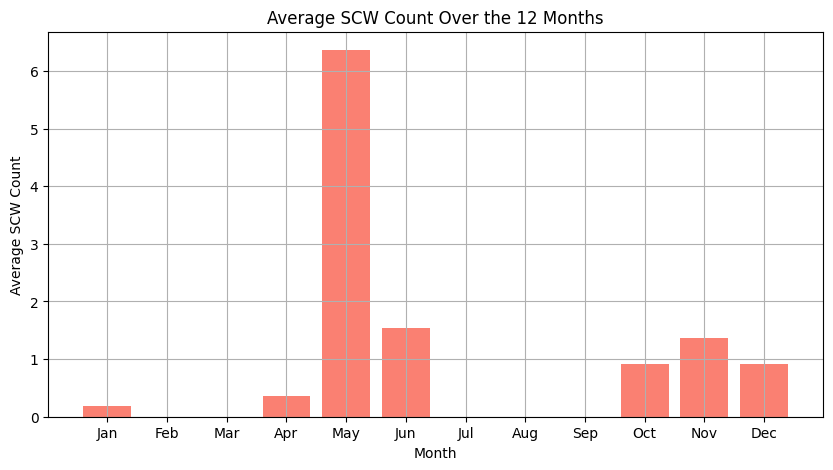

In [26]:
start_dates = [Time(t, format='mjd').datetime for t in scw_start_times]
years = [date.year for date in start_dates]
months = [date.month for date in start_dates]

year_month = [(year, month) for year, month in zip(years, months)]
year_month_count = pd.Series(year_month).value_counts().sort_index()
year_month_labels = [f'{year}-{month:02d}' for year, month in sorted(year_month_count.index)]
scw_year_month_counts = year_month_count.sort_index().values

yearly_count = {year: years.count(year) for year in set(years)}
monthly_count = {month: months.count(month) for month in range(1, 13)}

years_unique = sorted(yearly_count.keys())
scw_yearly = [yearly_count[year] for year in years_unique]

months_unique = list(range(1, 13))
scw_monthly_avg = [monthly_count[month] / len(years_unique) for month in months_unique]

plt.figure(figsize=(12, 6))
plt.bar(year_month_labels, scw_year_month_counts, color='lightgreen')
plt.title('SCW Count Over Months Across Years')
plt.xlabel('Year-Month')
plt.ylabel('Number of SCWs')
plt.xticks(np.arange(0, len(year_month_labels), 12), labels=[year_month_labels[i] for i in range(0, len(year_month_labels), 12)], rotation=45)
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(10, 5))
plt.bar(months_unique, scw_monthly_avg, color='salmon')
plt.title('Average SCW Count Over the 12 Months')
plt.xlabel('Month')
plt.ylabel('Average SCW Count')
plt.xticks(months_unique, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)


In [27]:
epochs = {'start':'2003-01-01', 'stop':'2025-01-01', 'step':'31d'}
jupiter = Horizons(id='sun', location='@599', epochs=epochs) 
eph = jupiter.ephemerides()
ra_values = eph['RA']
dec_values = eph['DEC']
datetime_values = eph['datetime_jd']

jupiter_coords = SkyCoord(ra=ra_values, dec=dec_values, unit=(u.deg, u.deg))

epochs = {'start':'2003-01-01', 'stop':'2025-01-01', 'step':'31d'}
sun = Horizons(id='sun', location='@0', epochs=epochs) 
eph = sun.ephemerides()
ra_values = eph['RA']
dec_values = eph['DEC']

sun_coords = SkyCoord(ra=ra_values, dec=dec_values, unit=(u.deg, u.deg))

years = np.array([eph['datetime_str'][i][:7] for i in range(len(eph))], dtype=str)

In [28]:
angles = sun_coords.separation(jupiter_coords).deg
dates = pd.date_range(start='2003-01-01', periods=260, freq='M')

yearly_avg = [np.mean(angles[i:i+12]) for i in range(0, len(angles), 12)]
monthly_avg = []
for month in range(12):
    month_indices = [i for i in range(len(angles)) if dates[i].month == month + 1]
    monthly_avg.append(np.mean(angles[month_indices]))

/tmp/ipykernel_12468/4246961367.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2003-01-01', periods=260, freq='M')


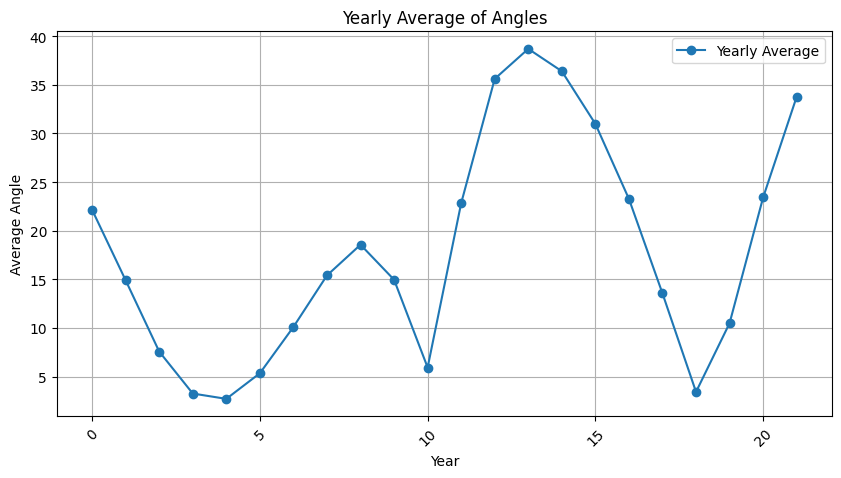

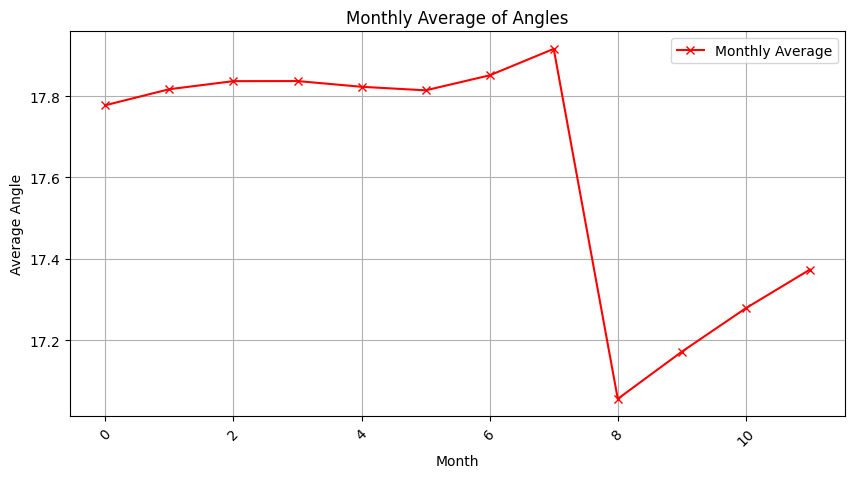

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(yearly_avg, label='Yearly Average', marker='o')
plt.title('Yearly Average of Angles')
plt.xlabel('Year')
plt.ylabel('Average Angle')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg, label='Monthly Average', marker='x', color='r')
plt.title('Monthly Average of Angles')
plt.xlabel('Month')
plt.ylabel('Average Angle')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

## Crab v Sun

In [6]:
scw = []
start = []
end = []

with open("../data/Crab-ScWs.txt", "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split(", ")
        scw.append(parts[0])
        start.append(float(parts[1]))  
        end.append(float(parts[2]))  

unique_sorted_data = {}
for scw, start, end in sorted(zip(scw, start, end), key=lambda x: x[0]):
    if scw not in unique_sorted_data:  
        unique_sorted_data[scw] = (scw, start, end)

scw, start, end = map(list, zip(*unique_sorted_data.values()))
durations = [e-s for e,s in zip(end, start)]

In [17]:
isot_start_times = Time(start, format='mjd').isot
isot_end_times = Time(end, format='mjd').isot
duration_seconds = [duration * 86400 for duration in durations]
year_months = [st[:7] for st in isot_start_times]

Plot distribution of the ScWs over time and the angular seperation between the Crab and the Sun.

In [20]:
crab = SkyCoord.from_name("Crab")
ra = crab.ra.deg
dec = crab.dec.deg
crab_coords = SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg))

epochs = {'start':'2003-01-01', 'stop':'2025-01-01', 'step':'31d'}
sun = Horizons(id='sun', location='@0', epochs=epochs) 
eph = sun.ephemerides()
ra_values = eph['RA']
dec_values = eph['DEC']
datetime_values = eph['datetime_jd']

sun_coords = SkyCoord(ra=ra_values, dec=dec_values, unit=(u.deg, u.deg))

years = np.array([eph['datetime_str'][i][:7] for i in range(len(eph))], dtype=str)

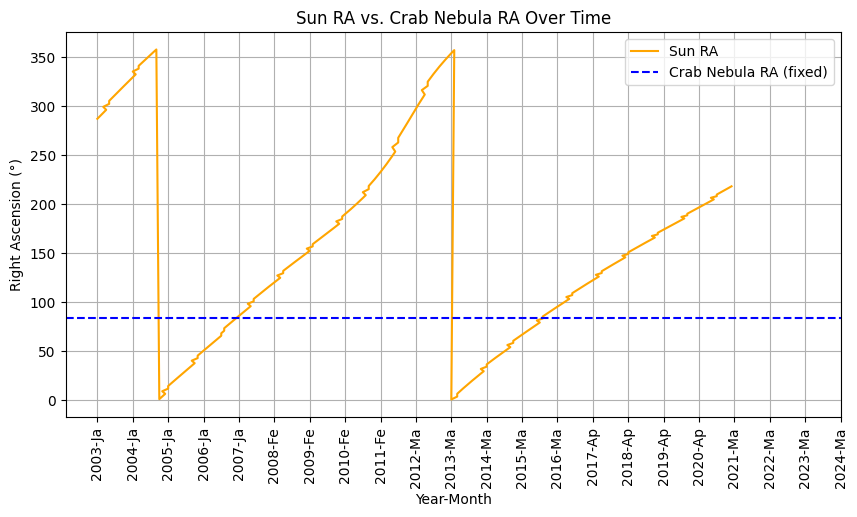

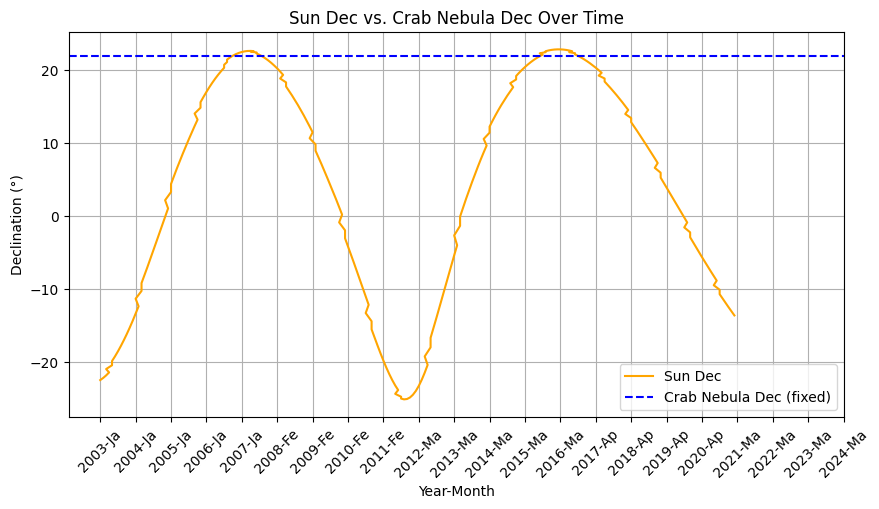

In [30]:
tick_indices = np.arange(0, len(years), 12)
tick_labels = years[tick_indices]

plt.figure(figsize=(10, 5))
plt.plot(years, ra_values, label="Sun RA", color='orange')
plt.axhline(y=ra, color='blue', linestyle='--', label="Crab Nebula RA (fixed)")
plt.xticks(ticks=tick_indices, labels=tick_labels, rotation=90)
plt.xlabel("Year-Month")
plt.ylabel("Right Ascension (°)")
plt.title("Sun RA vs. Crab Nebula RA Over Time")
plt.legend()
plt.grid()

plt.figure(figsize=(10, 5))
plt.plot(years, dec_values, label="Sun Dec", color='orange')
plt.axhline(y=dec, color='blue', linestyle='--', label="Crab Nebula Dec (fixed)")
plt.xticks(ticks=tick_indices, labels=tick_labels, rotation=45)
plt.xlabel("Year-Month")
plt.ylabel("Declination (°)")
plt.title("Sun Dec vs. Crab Nebula Dec Over Time")
plt.legend()
plt.grid()


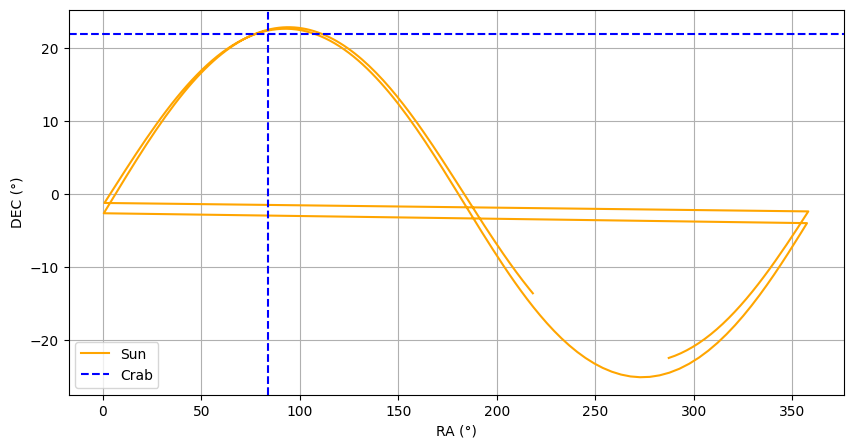

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(ra_values, dec_values, label="Sun", color='orange')
plt.axhline(y=dec, color='blue', linestyle='--', label="Crab")
plt.axvline(x=ra, color='blue', linestyle='--')
plt.xlabel("RA (°)")
plt.ylabel("DEC (°)")
plt.legend()
plt.grid()

In [ ]:
angles = sun_coords.separation(crab_coords).deg
dates = pd.date_range(start='2003-01-01', periods=260, freq='M')

yearly_avg = [np.mean(angles[i:i+12]) for i in range(0, len(angles), 12)]
monthly_avg = []
for month in range(12):
    month_indices = [i for i in range(len(angles)) if dates[i].month == month + 1]
    monthly_avg.append(np.mean(angles[month_indices]))

Yearly Averages: [142.28613478815373, 106.35765153020502, 70.8803876788816, 38.252820677978185, 9.671421004120084, 19.227224516203876, 46.49379157875391, 74.60333863214184, 105.47156878492426, 142.66734311415345, 164.06952319819968, 116.43139343942262, 74.29712550441128, 42.80351759762254, 16.983759040764145, 7.323515297477644, 27.97459881896843, 49.279625740956185, 70.42696370153487, 91.54495818899403, 112.57840019656413, 130.00585024460335]
Monthly Averages: [76.0266407674818, 75.96667133164752, 75.92707403520043, 75.9725546086232, 75.86464765746229, 75.69092164913063, 75.52378598635912, 75.37070264444358, 72.24872861026289, 72.0424380893623, 72.02829034222552, 72.06157092740342]


/tmp/ipykernel_5709/3303049636.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2003-01-01', periods=260, freq='M')


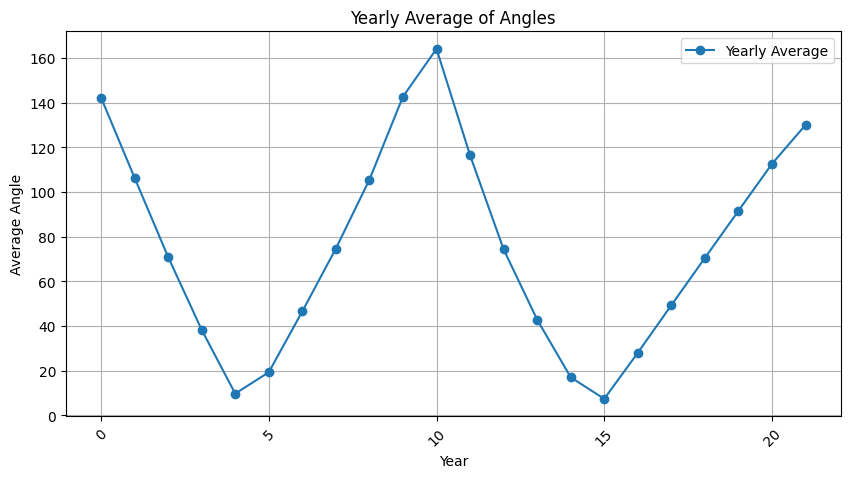

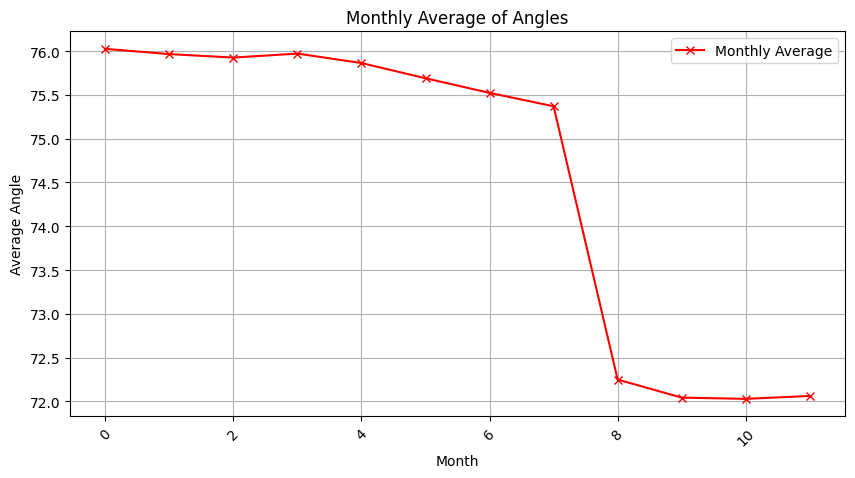

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(yearly_avg, label='Yearly Average', marker='o')
plt.title('Yearly Average of Angles')
plt.xlabel('Year')
plt.ylabel('Average Angle')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg, label='Monthly Average', marker='x', color='r')
plt.title('Monthly Average of Angles')
plt.xlabel('Month')
plt.ylabel('Average Angle')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

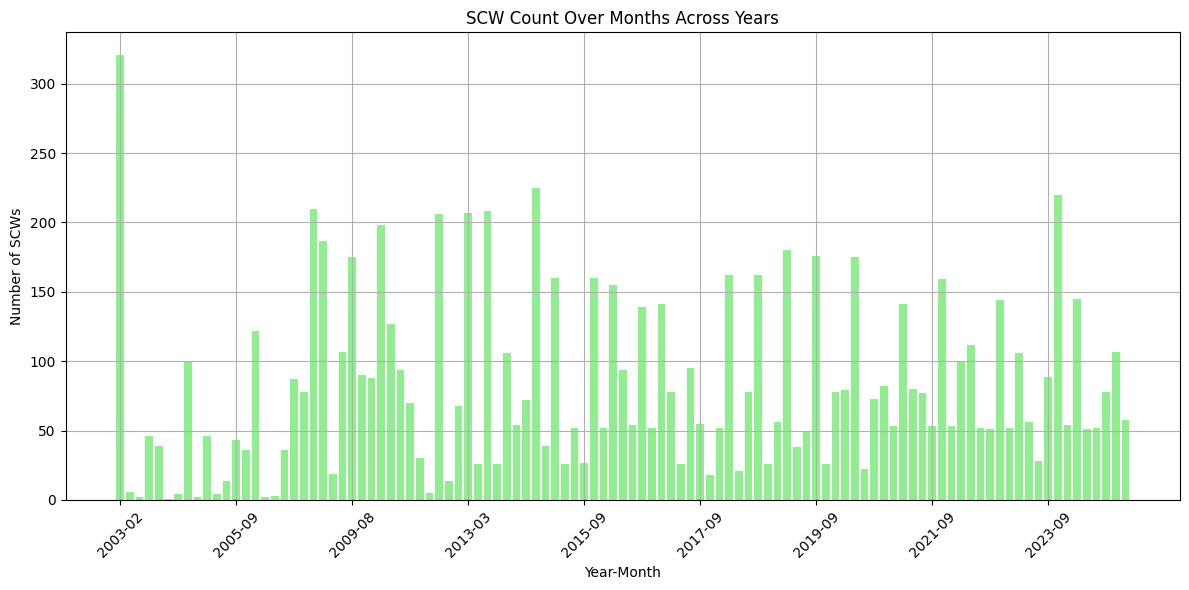

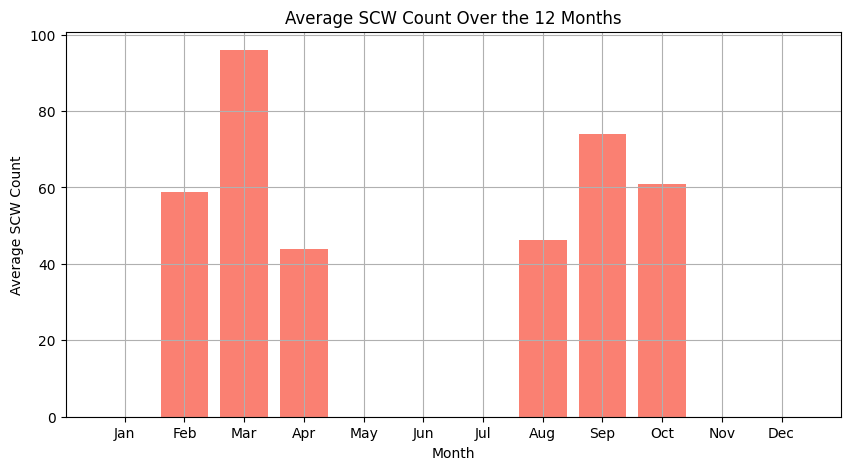

In [8]:
start_dates = [Time(t, format='mjd').datetime for t in start]
years = [date.year for date in start_dates]
months = [date.month for date in start_dates]

year_month = [(year, month) for year, month in zip(years, months)]
year_month_count = pd.Series(year_month).value_counts().sort_index()
year_month_labels = [f'{year}-{month:02d}' for year, month in sorted(year_month_count.index)]
scw_year_month_counts = year_month_count.sort_index().values

yearly_count = {year: years.count(year) for year in set(years)}
monthly_count = {month: months.count(month) for month in range(1, 13)}

years_unique = sorted(yearly_count.keys())
scw_yearly = [yearly_count[year] for year in years_unique]

months_unique = list(range(1, 13))
scw_monthly_avg = [monthly_count[month] / len(years_unique) for month in months_unique]

plt.figure(figsize=(12, 6))
plt.bar(year_month_labels, scw_year_month_counts, color='lightgreen')
plt.title('SCW Count Over Months Across Years')
plt.xlabel('Year-Month')
plt.ylabel('Number of SCWs')
plt.xticks(np.arange(0, len(year_month_labels), 12), labels=[year_month_labels[i] for i in range(0, len(year_month_labels), 12)], rotation=45)
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(10, 5))
plt.bar(months_unique, scw_monthly_avg, color='salmon')
plt.title('Average SCW Count Over the 12 Months')
plt.xlabel('Month')
plt.ylabel('Average SCW Count')
plt.xticks(months_unique, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
